In [12]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import torch.quantization as tq
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.nn import Linear, Conv2d
import torch.optim as optim
from torchsummary import summary

In [13]:
# Directories
test_dir = 'chest_xray/test'
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'

In [14]:
# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check which device you're using
print(f'Using device: {device}')

# Additional Info when using cuda
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print('Memory Usage:')
    print(f'Allocated: {round(torch.cuda.memory_allocated(0)/1024**3,1)} GB')
    print(f'Cached:    {round(torch.cuda.memory_reserved(0)/1024**3,1)} GB')

Using device: cuda
GPU: NVIDIA GeForce MX450
Memory Usage:
Allocated: 0.2 GB
Cached:    1.4 GB


In [15]:
class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.file_paths = [os.path.join(subdir, file) for subdir, dirs, files in os.walk(directory) for file in files]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        img = Image.open(file_path).convert('RGB')
        img = img.resize((150, 150))
        label = 0 if 'NORMAL' in file_path else 1  # 0 = Normal, 1 = Pneumonia
        if self.transform:
            img = self.transform(img)
        return img, label

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [16]:
# Load images from each directory
train_data = ImageDataset(train_dir, transform=transform)
test_data = ImageDataset(test_dir, transform=transform)
val_data = ImageDataset(val_dir, transform=transform)

In [17]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [18]:
print(f"Number of training images: {len(train_data)}")
print(f"Number of validation images: {len(val_data)}")
print(f"Number of testing images: {len(test_data)}")

Number of training images: 5216
Number of validation images: 16
Number of testing images: 624


In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 36 * 36, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 36 * 36)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create the model
model = Net()

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [20]:
summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
            Conv2d-3           [-1, 64, 72, 72]          18,496
         MaxPool2d-4           [-1, 64, 36, 36]               0
            Linear-5                  [-1, 128]      10,616,960
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 4]             516
Total params: 10,636,868
Trainable params: 10,636,868
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 9.85
Params size (MB): 40.58
Estimated Total Size (MB): 50.68
----------------------------------------------------------------


In [21]:
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler

# Number of epochs to train for
num_epochs = 15

# Lists to store per-epoch loss and accuracy values for training and validation
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0  # For model checkpointing

# Iterate over the data
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, data in progress_bar:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        current_loss = running_loss/(i+1)
        current_acc = correct_predictions/total_predictions
        progress_bar.set_description(f"Epoch {epoch+1} Loss: {current_loss:.4f}, Acc: {current_acc * 100:.2f}%")

    train_loss = running_loss / len(train_loader)
    train_acc = correct_predictions / total_predictions
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    val_loss = running_loss / len(val_loader)
    val_acc = correct_predictions / total_predictions
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Checkpoint the model if it has the best validation accuracy so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Update the learning rate
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f} Train Acc: {train_acc * 100:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc * 100:.2f}%')

print('Finished Training')

Epoch 1 Loss: 0.2125, Acc: 91.18%: 100%|██████████| 82/82 [03:43<00:00,  2.72s/it]


Epoch 1/15 Train Loss: 0.2125 Train Acc: 91.18% Val Loss: 0.3536 Val Acc: 87.50%


Epoch 2 Loss: 0.0839, Acc: 96.91%: 100%|██████████| 82/82 [03:47<00:00,  2.78s/it]


Epoch 2/15 Train Loss: 0.0839 Train Acc: 96.91% Val Loss: 0.4335 Val Acc: 81.25%


Epoch 3 Loss: 0.0704, Acc: 97.53%: 100%|██████████| 82/82 [03:55<00:00,  2.88s/it]


Epoch 3/15 Train Loss: 0.0704 Train Acc: 97.53% Val Loss: 0.1368 Val Acc: 93.75%


Epoch 4 Loss: 0.0531, Acc: 98.04%: 100%|██████████| 82/82 [03:38<00:00,  2.66s/it]


Epoch 4/15 Train Loss: 0.0531 Train Acc: 98.04% Val Loss: 0.4749 Val Acc: 81.25%


Epoch 5 Loss: 0.0466, Acc: 98.47%: 100%|██████████| 82/82 [03:51<00:00,  2.82s/it]


Epoch 5/15 Train Loss: 0.0466 Train Acc: 98.47% Val Loss: 0.1746 Val Acc: 93.75%


Epoch 6 Loss: 0.0419, Acc: 98.54%: 100%|██████████| 82/82 [03:33<00:00,  2.61s/it]


Epoch 6/15 Train Loss: 0.0419 Train Acc: 98.54% Val Loss: 0.1109 Val Acc: 93.75%


Epoch 7 Loss: 0.0285, Acc: 99.04%: 100%|██████████| 82/82 [03:49<00:00,  2.80s/it]


Epoch 7/15 Train Loss: 0.0285 Train Acc: 99.04% Val Loss: 0.1607 Val Acc: 93.75%


Epoch 8 Loss: 0.0225, Acc: 99.14%: 100%|██████████| 82/82 [03:10<00:00,  2.32s/it]


Epoch 8/15 Train Loss: 0.0225 Train Acc: 99.14% Val Loss: 0.3819 Val Acc: 81.25%


Epoch 9 Loss: 0.0233, Acc: 99.10%: 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]


Epoch 9/15 Train Loss: 0.0233 Train Acc: 99.10% Val Loss: 0.2051 Val Acc: 87.50%


Epoch 10 Loss: 0.0137, Acc: 99.52%: 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]


Epoch 10/15 Train Loss: 0.0137 Train Acc: 99.52% Val Loss: 0.1213 Val Acc: 93.75%


Epoch 11 Loss: 0.0086, Acc: 99.77%: 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]


Epoch 11/15 Train Loss: 0.0086 Train Acc: 99.77% Val Loss: 0.2565 Val Acc: 87.50%


Epoch 12 Loss: 0.0053, Acc: 99.87%: 100%|██████████| 82/82 [02:24<00:00,  1.76s/it]


Epoch 12/15 Train Loss: 0.0053 Train Acc: 99.87% Val Loss: 0.3126 Val Acc: 87.50%


Epoch 13 Loss: 0.0052, Acc: 99.88%: 100%|██████████| 82/82 [02:21<00:00,  1.73s/it]


Epoch 13/15 Train Loss: 0.0052 Train Acc: 99.88% Val Loss: 0.1679 Val Acc: 93.75%


Epoch 14 Loss: 0.0047, Acc: 99.90%: 100%|██████████| 82/82 [02:23<00:00,  1.75s/it]


Epoch 14/15 Train Loss: 0.0047 Train Acc: 99.90% Val Loss: 0.1723 Val Acc: 93.75%


Epoch 15 Loss: 0.0035, Acc: 99.92%: 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]


Epoch 15/15 Train Loss: 0.0035 Train Acc: 99.92% Val Loss: 0.1839 Val Acc: 93.75%
Finished Training


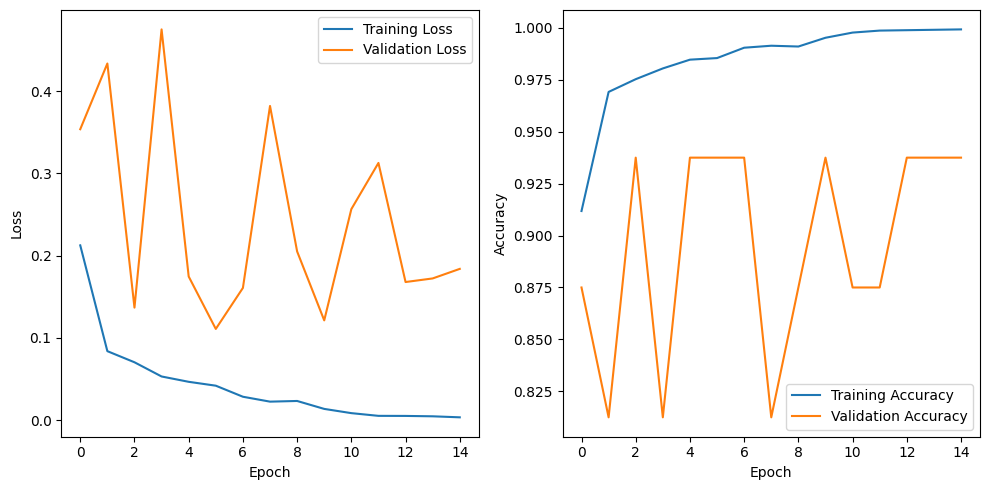

In [22]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('plots/training_validation_plot.png', dpi=300)
plt.show()

In [23]:
torch.save(model.state_dict(), 'model.pth')

In [28]:
model = Net()  # Initialize the model
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

In [29]:
total = 0
correct = 0

with torch.no_grad():
    for data in tqdm(test_loader, desc="Predicting..."):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('\nAccuracy of the network on the test images: {:.2f} %'.format(
    100 * correct / total))

Predicting...: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Accuracy of the network on the test images: 79.33 %


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Store all labels and predictions
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in tqdm(test_loader, desc="Predicting..."):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Print classification report
print("\n" + "="*30)
print(classification_report(all_labels, all_predictions))
print("="*30 + "\n")

Predicting...: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


              precision    recall  f1-score   support

           0       0.94      0.44      0.60       234
           1       0.74      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624




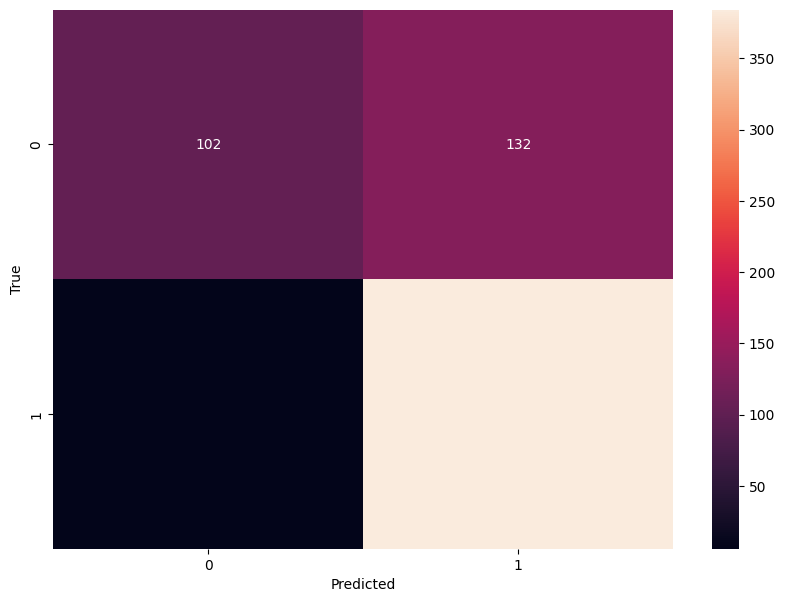

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()